<a href="https://colab.research.google.com/github/SantonioTheFirst/Cats_VS_Dogs_image_classification/blob/main/Cats_VS_Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d salader/dogs-vs-cats

 99% 1.06G/1.06G [00:34<00:00, 59.9MB/s]
100% 1.06G/1.06G [00:34<00:00, 33.1MB/s]


In [3]:
!unzip -q dogs-vs-cats

In [18]:
import numpy as np

import tensorflow
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, BatchNormalization, Flatten, Input
from tensorflow.keras.layers import CenterCrop, Rescaling, Resizing
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, plot_model, image_dataset_from_directory
from tensorflow.keras.optimizers import Adam
from tensorflow.data.experimental import AUTOTUNE

%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import os


image_size = (224, 224)
image_shape = (224, 224, 3)

batch_size = 32

In [19]:
train_ds = image_dataset_from_directory(
    'train', batch_size=batch_size, validation_split=0.1, subset='training', seed=42, label_mode='categorical'
)
test_ds = image_dataset_from_directory('test', batch_size=batch_size, label_mode='categorical', seed=42)
val_ds = image_dataset_from_directory(
    'train', batch_size=batch_size, validation_split=0.1, subset='validation', seed=42, label_mode='categorical'
)

Found 20000 files belonging to 2 classes.
Using 18000 files for training.
Found 5000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Using 2000 files for validation.


In [20]:
train_ds

<BatchDataset shapes: ((None, 256, 256, 3), (None, 2)), types: (tf.float32, tf.float32)>

In [21]:
def get_model():
    inputs = Input(shape=(None, None, 3))
    # x = CenterCrop(*image_size)(inputs)
    x = Resizing(*image_size)(inputs)
    x = Rescaling(1.0 / 255.0)(x)

    base_model = MobileNetV2(input_shape=image_shape, include_top=False)
    base_model.trainable = False

    base_model_output = base_model(x, training=False)
    x = tensorflow.keras.layers.GlobalMaxPooling2D()(base_model_output)
    x = Dropout(0.2)(x)
    x = Dense(64, 'relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(2, 'softmax')(x)

    model = Model(inputs, outputs)

    return model

In [22]:
model = get_model()

In [23]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_max_pooling2d_1 (Glo  (None, 1280)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0   

In [24]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
es = EarlyStopping(patience=5, restore_best_weights=True)

In [26]:
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

In [27]:
train_ds

<PrefetchDataset shapes: ((None, 256, 256, 3), (None, 2)), types: (tf.float32, tf.float32)>

In [28]:
epochs = 25
history = model.fit(train_ds, epochs=epochs, callbacks=[es], validation_data=val_ds)

Epoch 1/25
563/563 [==============================] - 63s 105ms/step - loss: 0.1326 - accuracy: 0.9588 - val_loss: 0.0682 - val_accuracy: 0.9750
Epoch 2/25
563/563 [==============================] - 59s 103ms/step - loss: 0.0635 - accuracy: 0.9755 - val_loss: 0.0535 - val_accuracy: 0.9800
Epoch 3/25
563/563 [==============================] - 58s 103ms/step - loss: 0.0553 - accuracy: 0.9779 - val_loss: 0.0509 - val_accuracy: 0.9810
Epoch 4/25
563/563 [==============================] - 58s 102ms/step - loss: 0.0497 - accuracy: 0.9814 - val_loss: 0.0516 - val_accuracy: 0.9825
Epoch 5/25
563/563 [==============================] - 58s 102ms/step - loss: 0.0506 - accuracy: 0.9813 - val_loss: 0.0498 - val_accuracy: 0.9855
Epoch 6/25
563/563 [==============================] - 58s 103ms/step - loss: 0.0467 - accuracy: 0.9826 - val_loss: 0.0505 - val_accuracy: 0.9830
Epoch 7/25
563/563 [==============================] - 58s 103ms/step - loss: 0.0419 - accuracy: 0.9826 - val_loss: 0.0546 - val_ac

In [29]:
model.evaluate(test_ds)

157/157 [==============================] - 15s 91ms/step - loss: 0.0529 - accuracy: 0.9810


[0.05290132015943527, 0.9810000061988831]

In [30]:
import seaborn as sns
sns.set_style('darkgrid')

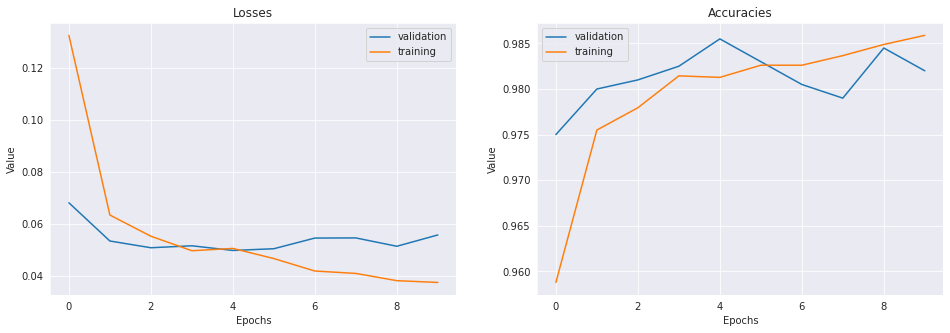

In [33]:
fig = plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['val_loss'], label='validation')
plt.plot(history.history['loss'], label='training')
plt.title('Losses')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.plot(history.history['val_accuracy'], label='validation')
plt.plot(history.history['accuracy'], label='training')
plt.title('Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend(loc='best')

plt.show()

In [34]:
model.save('cats_vs_dogs')

INFO:tensorflow:Assets written to: cats_vs_dogs/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [35]:
!zip -q -r cats_vs_dogs.zip cats_vs_dogs

In [36]:
from tensorflow.keras.models import load_model

In [ ]:
!unzip -q cats_vs_dogs.zip

In [37]:
t = load_model('cats_vs_dogs')

In [38]:
from PIL import Image
import numpy as np

In [39]:
!wget https://chicagolanddogrescue.org/wp-content/uploads/2020/04/Kermit-2.jpeg -O dog.jpg
!wget https://www.panaynews.net/wp-content/uploads/2019/12/Rabid-Dog.jpg -O dog2.jpg
!wget https://justsomething.co/wp-content/uploads/2019/01/meet-izzy-the-cat-with-the-funniest-facial-expressions-that-s-going-viral-on-instagram-13.jpg -O cat.jpg
!wget https://catvills.com/wp-content/uploads/2020/02/dumbest-cat-breeds-f-1.jpg -O cat2.jpg

--2022-01-10 14:41:30--  https://chicagolanddogrescue.org/wp-content/uploads/2020/04/Kermit-2.jpeg
Resolving chicagolanddogrescue.org (chicagolanddogrescue.org)... 35.209.61.18
Connecting to chicagolanddogrescue.org (chicagolanddogrescue.org)|35.209.61.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 955849 (933K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>] 933.45K  1.07MB/s    in 0.9s    

2022-01-10 14:41:32 (1.07 MB/s) - ‘dog.jpg’ saved [955849/955849]

--2022-01-10 14:41:32--  https://www.panaynews.net/wp-content/uploads/2019/12/Rabid-Dog.jpg
Resolving www.panaynews.net (www.panaynews.net)... 192.124.249.20
Connecting to www.panaynews.net (www.panaynews.net)|192.124.249.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139855 (137K) [image/jpeg]
Saving to: ‘dog2.jpg’

dog2.jpg            100%[===================>] 136.58K   259KB/s    in 0.5s    

2022-01-10 14:41:34 (259 KB/s) - ‘dog2.jpg’

In [40]:
cat = Image.open('cat.jpg')

In [42]:
t.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_max_pooling2d_1 (Glo  (None, 1280)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0   

In [47]:
transformed_cat = np.asarray(t.layers[1](np.asarray(cat)), dtype=np.uint8)
transformed_cat_img = Image.fromarray(transformed_cat)

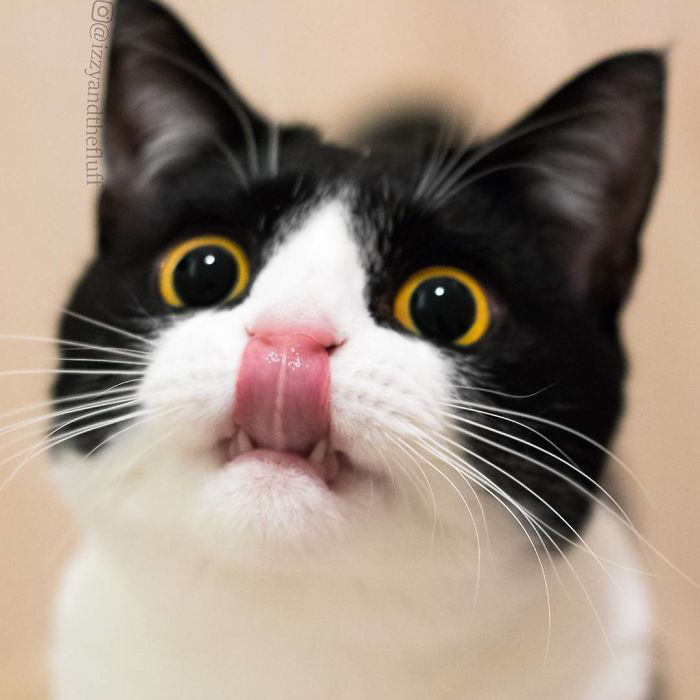

In [49]:
cat

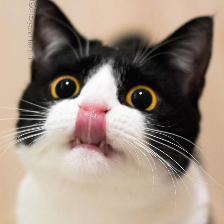

In [50]:
transformed_cat_img

In [48]:
classes = np.array(['cat', 'dog'])

In [51]:
cat_prediction = t.predict(np.expand_dims(np.asarray(cat), axis=0))
print(f'Cat: {cat_prediction[0][0] * 100}, Dog: {cat_prediction[0][1] * 100}')

Cat: 100.0, Dog: 9.331856176686415e-07


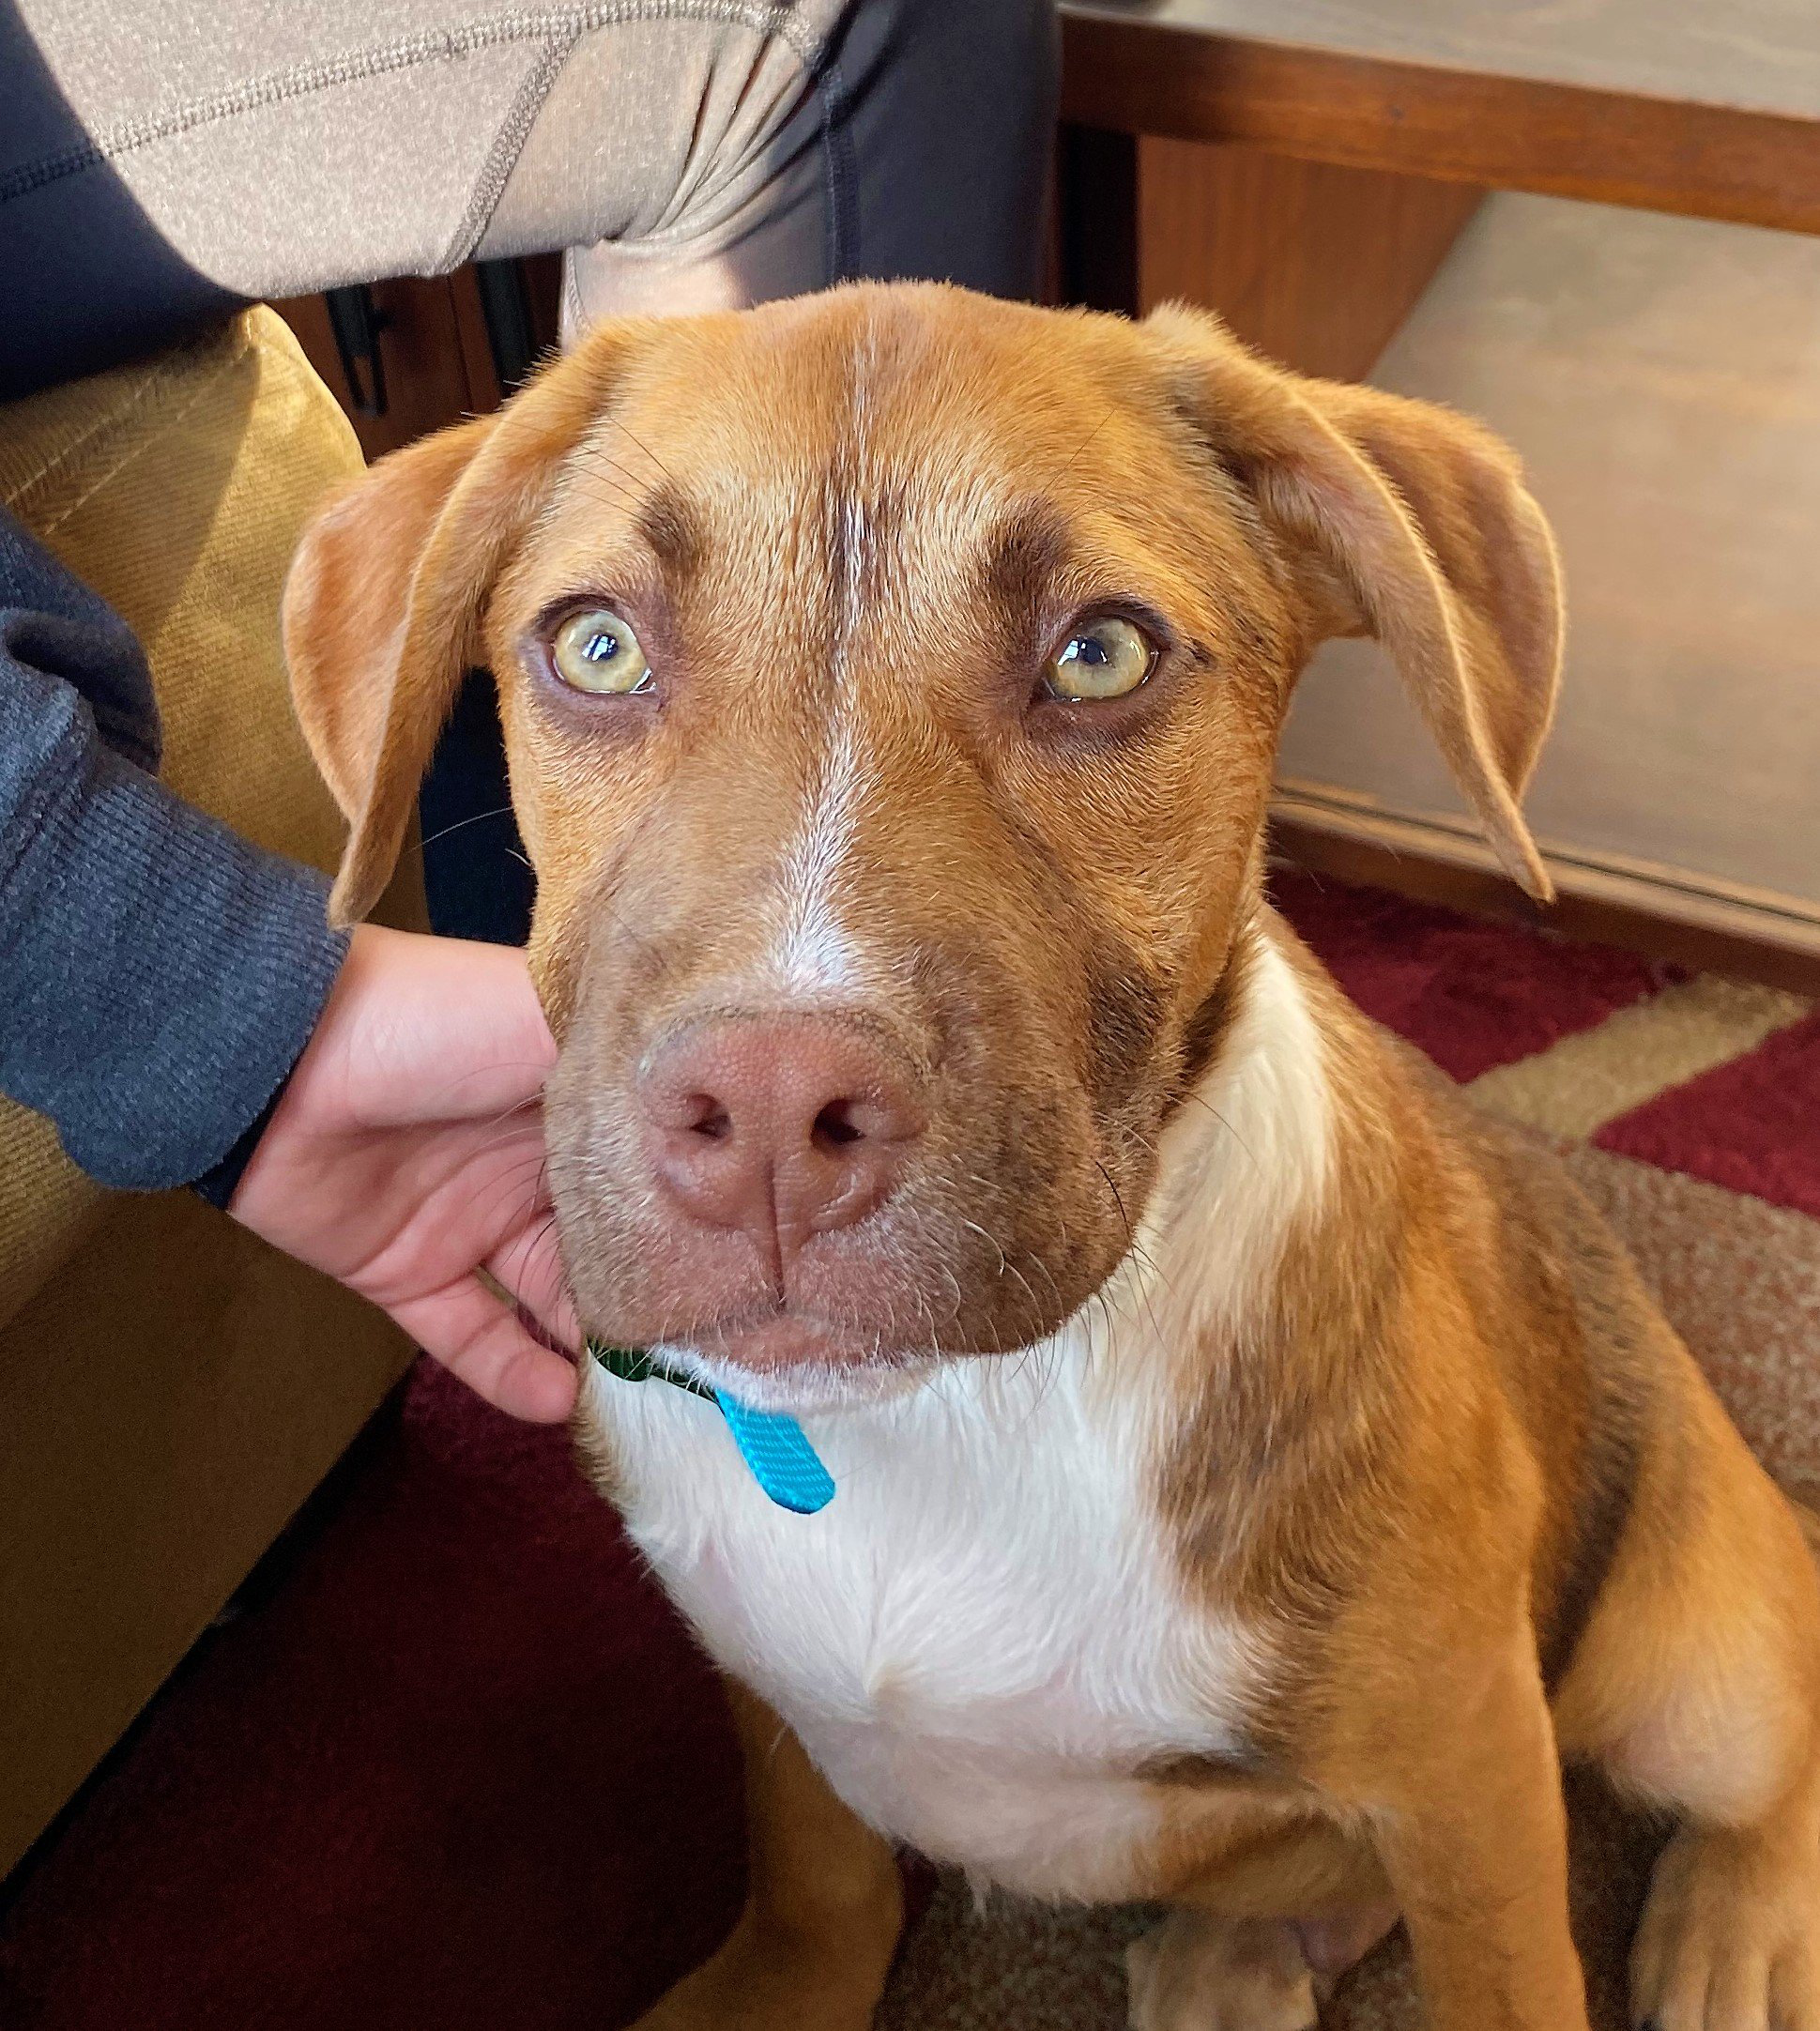

In [52]:
dog = Image.open('dog.jpg')
transformed_dog = np.asarray(t.layers[1](np.asarray(dog)), dtype=np.uint8)
transformed_dog_img = Image.fromarray(np.asarray(transformed_dog))
dog

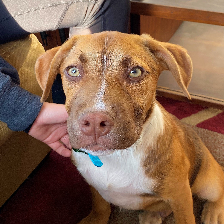

In [53]:
transformed_dog_img

In [54]:
dog_prediction = t.predict(np.expand_dims(np.asarray(dog), axis=0))
print(f'Cat: {dog_prediction[0][0] * 100}, Dog: {dog_prediction[0][1] * 100}')

Cat: 9.522129289507575e-05, Dog: 99.99990463256836
